In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')

In [2]:
from src.wess_zumino_model import WessZuminoModel
from src.matrix_to_ps import matrix_to_pse
from src.binary_encodings import standard_encode
from src.qiskit_utilities import pauli_dict_to_op, op_to_trotter


from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes
from qiskit import BasicAer
from qiskit import qpy
from qiskit import QuantumCircuit, transpile


import scipy.sparse.linalg
import sympy as sp
import numpy as np

import math

In [3]:
def potential(self, n):
    # m*q with m=1
    return -self.mass*self.qs[n]

In [4]:
N=2
wz=WessZuminoModel(N,1.0,potential,'dirichlet')

In [14]:
for cutoff in [2,4,8,12,16,24,32]:
    print("------ cutoff = {} ------".format(cutoff))
    #CLASSICAL COMPUTATION OF GROUND STATE ENERGY
    wz.construct_ham_matrix(cutoff)
    ens=scipy.sparse.linalg.eigs(wz.hamMat,k=7,sigma=0.0)[0]
    print("Lowest 7 energies = {}".format(ens))
    print("Min energy = {:.4e}".format(np.array([x.real for x in ens]).min()))

    #VQE COMPUTATION OF GROUND STATE ENERGY
    ps=matrix_to_pse(wz.hamMat, standard_encode)
    op=pauli_dict_to_op(ps.to_dict())


    nq=math.floor(math.log2(wz.hamMat.shape[0]))
    if not math.log2(wz.hamMat.shape[0]).is_integer():
        nq+=1

    ansatz = RealAmplitudes(nq, reps=cutoff)    
    backend = BasicAer.get_backend("statevector_simulator")
    vqe = VQE(ansatz=ansatz, optimizer=COBYLA(), quantum_instance=backend)
    results=[]
    for i in range(50):
        results.append(vqe.compute_minimum_eigenvalue(op).eigenvalue.real)
    en = np.array(results).min()
    print("VQE estimates of energy = {}".format(results))
    print("VQE min = {:.4e}".format(en))

    qc = QuantumCircuit(nq,nq)
    qc.append(op_to_trotter(op,0.1), [i for i in range(nq)])
    tmp = transpile(qc, basis_gates = ['cx', 'u1', 'u2', 'u3', 'H', 'X', 'Y', 'Z'])
    print("gates for one trotter step = ", tmp.count_ops().get('cx'))
    print()

------ cutoff = 2 ------
Lowest 7 energies = [0.00696601+1.5463879e-10j 1.1249996 +8.4866720e-08j
 0.00696601+2.0597696e-10j 0.00696601+4.6277336e-11j
 0.00696601-3.1916308e-12j 1.1249962 -1.7916197e-07j
 1.1249999 -1.1510790e-09j]
Min energy = 6.9660e-03
VQE estimates of energy = [0.006966018841231636, 0.006966016218941565, 0.006966016348865053, 0.006966033930090884, 0.006968607405705438, 0.006966029223167032, 0.006966018284050631, 0.006966021146265633, 0.006966036735819449, 0.006966013020595138, 0.0069660405195382, 0.006966313961663732, 0.006966021546441144, 0.006966060338438365, 0.006966030906524284, 0.006966035884336941, 0.006966036315635966, 0.006970050330612042, 0.007092261539170582, 0.006966134681925617, 0.006966015267633279, 0.006966039699494553, 0.006966021504736537, 0.006971865297664488, 0.00698026048827818, 0.0069660353042382, 0.006995650610272078, 0.00696604923429938, 0.006966070950512332, 0.00696605361287028, 0.006966037065894996, 0.006968882211544782, 0.006966014171253284

In [26]:
cutoff=16
wz.construct_ham_matrix(cutoff)
ens=scipy.sparse.linalg.eigs(wz.hamMat,k=7,sigma=0.0)[0]
ps=matrix_to_pse(wz.hamMat, standard_encode)
op=pauli_dict_to_op(ps.to_dict())

nq=math.floor(math.log2(wz.hamMat.shape[0]))
print(nq)
if not math.log2(wz.hamMat.shape[0]).is_integer():
    nq+=1

10


## TODO

* Plot classical psi(x,lambda), is it gaussian around x=0, lambda=0?

B_0 x F_0 x B_1 x F_1  # F and B are matrices

(b^0_0 b^1_0 b^2_0) x (f^0_0 f^1_0) ? (b^0_1 b^1_1 b^2_1) x (f^0_1 f^1_1)

(b^0_0f^0_0 b^0_0f^1_0 b^1_0f^0_0 b^1_0f^1_0 b^2_0f^0_0 b^2_0f^1_0) ? (b^0_1f^0_1 b^0_1f^1_1 b^1_1f^0_1 b^1_1f^1_1 b^2_1f^0_1 b^2_1f^1_1)


In [59]:
import matplotlib.pyplot as plt
cutoff=16
wz.construct_ham_matrix(cutoff)
eigSys=scipy.sparse.linalg.eigs(wz.hamMat,k=1,sigma=0.0)

def idx(x,l,f):
    return x*(2**N)*cutoff + l*(2**N) + f

1024

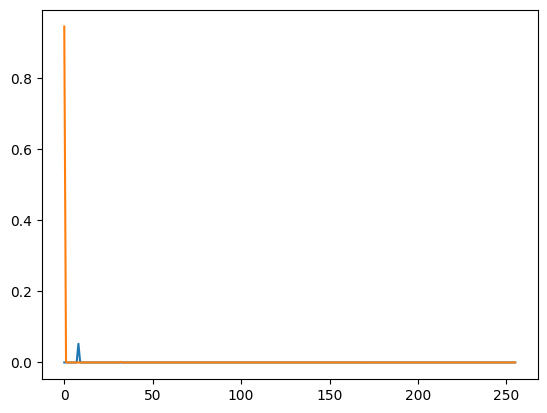

In [61]:
PSI = lambda s,l,f : eigSys[1][idx(s,l,f),0]

plt.plot([l for l in range(cutoff**N)], [PSI(0,l,0).real**2 + PSI(0,l,0).imag**2 for l in range(cutoff**N)])
plt.plot([l for l in range(cutoff**N)], [PSI(0,l,1).real**2 + PSI(0,l,1).imag**2 for l in range(cutoff**N)])

In [62]:
plt.plot([l for l in range(cutoff**N)], [PSI(1,l,0).real**2 + PSI(1,l,0).imag**2 for l in range(cutoff**N)])
plt.plot([l for l in range(cutoff**N)], [PSI(1,l,1).real**2 + PSI(1,l,1).imag**2 for l in range(cutoff**N)])

IndexError: index 1024 is out of bounds for axis 0 with size 1024